**Import libraries**

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os.path import join as pjoin
from os.path import exists
import librosa
import time
from tqdm import trange
import keras
from keras.layers import Conv2D,Flatten,Dense,Dropout,AveragePooling2D

Using TensorFlow backend.


In [2]:
# Audio sample related
num_mfcc_features = 13
num_fft = 2048
overlap_sample = 512
dct_type = 3
epochs = 100


# ML model related
learning_rate = 0.001
dropout_ratio = 0.2
loss_function = 'binary_crossentropy'

**Load audio samples**

In [3]:
dataset_path = 'G:\Audio Tagging (Smart City)\CASSE\chime_home'

train_file_path  = pd.read_csv(dataset_path+'\development_chunks_refined.csv',header=None)[1]
test_file_path = pd.read_csv(dataset_path+'\evaluation_chunks_refined.csv',header=None)[1]

**Extract MFCC-features**

In [4]:
if not exists('mfcc_features.npz'):
    file_name = pjoin(dataset_path+'\chunks\\' + train_file_path[0] +'.48kHz.wav')
    audio_signal,sampling_rate = librosa.load(file_name)
    feature_sample = librosa.feature.mfcc(audio_signal,sr=int(sampling_rate/2),n_mfcc=num_mfcc_features,dct_type=dct_type,n_fft=num_fft,hop_length=overlap_sample)

    train_features = np.zeros((len(train_file_path),num_mfcc_features,feature_sample.shape[1]),dtype=float)
    test_features = np.zeros((len(test_file_path),num_mfcc_features,feature_sample.shape[1]),dtype=float)

    trange_train_feature = trange(len(train_file_path),desc='Extracting MFCC features (Training)')
    for index in trange_train_feature:
        file_name = pjoin(dataset_path+'\chunks\\' + train_file_path[index] +'.48kHz.wav')
        audio_signal,sampling_rate = librosa.load(file_name)
        feature = librosa.feature.mfcc(audio_signal,sr=int(sampling_rate/2),n_mfcc=num_mfcc_features,dct_type=dct_type,n_fft=num_fft,hop_length=overlap_sample)
        train_features [index] = feature

    trange_test = trange(len(test_file_path),desc='Extracting MFCC features (Testing)')
    for index in trange_test_feature:
        file_name = pjoin(dataset_path+'\chunks\\' + test_file_path[index] +'.48kHz.wav')
        audio_signal,sampling_rate = librosa.load(file_name)
        feature = librosa.feature.mfcc(audio_signal,sr=int(sampling_rate/2),n_mfcc=num_mfcc_features,dct_type=dct_type,n_fft=num_fft,hop_length=overlap_sample)
        test_features [index] = feature


    np.savez('mfcc_features.npz',train_features,test_features)

else:
    npzload = np.load('mfcc_features.npz')
    train_features = npzload['arr_0']
    test_features = npzload['arr_1']

**Extract labels**

In [5]:
train_label = list()
test_label = list()

trange_train_label = trange(len(train_file_path),desc='Extracting Labels (Training)')
for index_train in trange_train_label:  
    filename_train = pjoin(dataset_path+'\chunks\\' + train_file_path[index_train] +'.csv')  
    file_info_train = pd.read_csv(filename_train,header=None)
    train_label.append(file_info_train.loc[9,1])
    

trange_test_label = trange(len(test_file_path),desc='Extracting Labels (Testing)')
for index_test in trange_test_label:  
    filename_test =pjoin(dataset_path+'\chunks\\' + test_file_path[index_test] +'.csv')  
    file_info_test = pd.read_csv(filename_test,header=None)
    test_label.append(file_info_test.loc[9,1])

Extracting Labels (Testing): 100%|██████████| 816/816 [00:01<00:00, 610.24it/s]


In [6]:
# Label encoding
enc_train_label = np.zeros((len(train_label),9),dtype=int)   # 9-Classes
enc_test_label = np.zeros((len(test_label),9),dtype=int)     # 9-Classes
counter = 0

label_dictionary = {
    'c' : 0,
    'm' : 1,
    'f' : 2,
    'v' : 3,
    'p' : 4,
    'b' : 5,
    'o' : 6,
    'S' : 7,
    'U' : 8
}

train_counter = 0
for each_label in train_label:
    for individual_label in each_label:
        enc_train_label[train_counter,label_dictionary[individual_label]] = 1
    train_counter+=1

test_counter = 0
for each_label in test_label:
    for individual_label in each_label:
        enc_test_label[test_counter,label_dictionary[individual_label]] = 1
    test_counter+=1

**Define machine learning model**

In [7]:
batch_size = 20

cnn_model = keras.models.Sequential()
cnn_model.add(Conv2D(32,kernel_size=5,strides=1,activation='relu',kernel_regularizer=keras.regularizers.l1(0.03),input_shape=(num_mfcc_features,train_features.shape[2],1)))
cnn_model.add(AveragePooling2D(strides=1))
cnn_model.add(Conv2D(16,kernel_size=3,strides=1,activation='relu',kernel_regularizer=keras.regularizers.l1(0.02),input_shape=(num_mfcc_features,train_features.shape[2],1)))
cnn_model.add(AveragePooling2D(strides=1))
cnn_model.add(Flatten())
cnn_model.add(Dense(32,activation='relu'))
cnn_model.add(Dropout(dropout_ratio))
cnn_model.add(Dense(9,activation='sigmoid'))

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

cnn_model.compile(loss=loss_function,optimizer=optimizer,metrics=['accuracy'])
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 9, 169, 32)        832       
_________________________________________________________________
average_pooling2d_1 (Average (None, 8, 168, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 166, 16)        4624      
_________________________________________________________________
average_pooling2d_2 (Average (None, 5, 165, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 13200)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                422432    
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)               

**Model training**

In [8]:
x_train, y_train = np.expand_dims(train_features,3), enc_train_label
x_test, y_test = np.expand_dims(test_features,3), enc_test_label

model_training = cnn_model.fit(x=x_train,y=y_train,epochs=epochs,validation_data=(x_test,y_test))

Train on 1946 samples, validate on 816 samples
Epoch 1/100
1946/1946 [==============================] - 4s 2ms/step - loss: 6.3320 - accuracy: 0.7807 - val_loss: 5.0328 - val_accuracy: 0.8361
Epoch 2/100
1946/1946 [==============================] - 0s 222us/step - loss: 4.4050 - accuracy: 0.8245 - val_loss: 3.7687 - val_accuracy: 0.8614
Epoch 3/100
1946/1946 [==============================] - 0s 211us/step - loss: 3.3348 - accuracy: 0.8439 - val_loss: 2.8867 - val_accuracy: 0.8588
Epoch 4/100
1946/1946 [==============================] - 0s 204us/step - loss: 2.5302 - accuracy: 0.8482 - val_loss: 2.1331 - val_accuracy: 0.8611
Epoch 5/100
1946/1946 [==============================] - 0s 221us/step - loss: 1.8901 - accuracy: 0.8486 - val_loss: 1.6083 - val_accuracy: 0.8661
Epoch 6/100
1946/1946 [==============================] - 0s 196us/step - loss: 1.4386 - accuracy: 0.8494 - val_loss: 1.2225 - val_accuracy: 0.8610
Epoch 7/100
1946/1946 [==============================] - 0s 201us/step - 

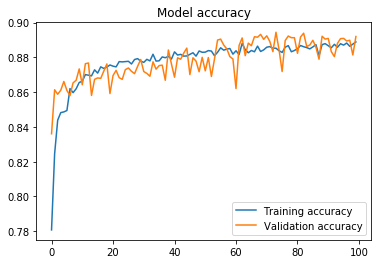

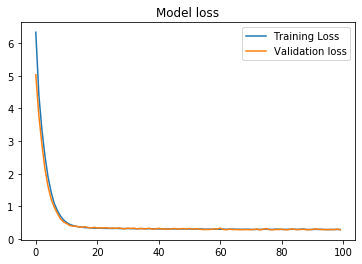

In [9]:
model_training.history.keys()

plt.plot(model_training.history['accuracy'])
plt.plot(model_training.history['val_accuracy'])
plt.legend(['Training accuracy','Validation accuracy'])
plt.title('Model accuracy')
plt.show()

print()
plt.plot(model_training.history['loss'])
plt.plot(model_training.history['val_loss'])
plt.legend(['Training Loss','Validation loss'])
plt.title('Model loss')
plt.show()